Total Gain: -1300.16
Average Gain/Trade: -6.92
Total Trades: 188
Win Rate: 42.02%
Max Drawdown: -1300.16
CAGR (approx): -1.36%


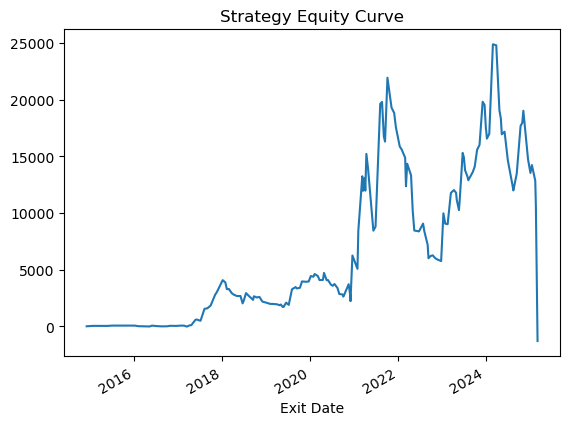

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data
df = pd.read_csv("data/BTCUSD/BTCUSD_daily.csv", parse_dates=["datetime"])
df.set_index("datetime", inplace=True)

# Calculate indicators
def ema(series, span):
    return series.ewm(span=span, adjust=False).mean()

df["EMA_fast"] = ema(df["close"], 6)
df["EMA_slow"] = ema(df["close"], 40)
df["MACD"] = df["EMA_fast"] - df["EMA_slow"]
df["Signal"] = ema(df["MACD"], 6)
df["Histogram"] = df["MACD"] - df["Signal"]
df["EMA5"] = ema(df["close"], 5)

# Backtest logic
position = 0
entry_price = 0
entry_date = None
max_holding = 20  # bars (days)
results = []

for i in range(1, len(df)):
    row, prev = df.iloc[i], df.iloc[i - 1]

    # Entry Condition
    if position == 0:
        histogram_cross = prev["Histogram"] <= 0 and row["Histogram"] > 0
        ema_filter = row["close"] > row["EMA5"]

        if histogram_cross and ema_filter:
            position = 1
            entry_price = row["close"]
            entry_date = row.name

    # Exit Condition
    elif position == 1:
        holding_period = (row.name - entry_date).days
        momentum_down = row["Histogram"] < prev["Histogram"]

        if momentum_down or holding_period >= max_holding:
            exit_price = row["close"]
            pnl = exit_price - entry_price
            results.append({
                "Entry Date": entry_date,
                "Exit Date": row.name,
                "Entry": entry_price,
                "Exit": exit_price,
                "PnL": pnl,
                "Holding Days": holding_period
            })
            position = 0

# Convert results to DataFrame
trades = pd.DataFrame(results)

# Summary
total_gain = trades["PnL"].sum()
avg_gain = trades["PnL"].mean()
win_rate = (trades["PnL"] > 0).mean()
max_drawdown = trades["PnL"].cumsum().min()
cagr = ((1 + trades["PnL"].sum()/10000)**(365/len(df)) - 1) * 100  # assuming starting capital = 10k

print(f"Total Gain: {total_gain:.2f}")
print(f"Average Gain/Trade: {avg_gain:.2f}")
print(f"Total Trades: {len(trades)}")
print(f"Win Rate: {win_rate * 100:.2f}%")
print(f"Max Drawdown: {max_drawdown:.2f}")
print(f"CAGR (approx): {cagr:.2f}%")

# Optional: plot equity curve
trades["Equity"] = trades["PnL"].cumsum()
trades.set_index("Exit Date")["Equity"].plot(title="Strategy Equity Curve")
plt.show()
